0) **Imports**

In [11]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np
import matplotlib.pyplot as plt
import fetricks as ft

1) **Consititutive behaviour Definition**

shuffling


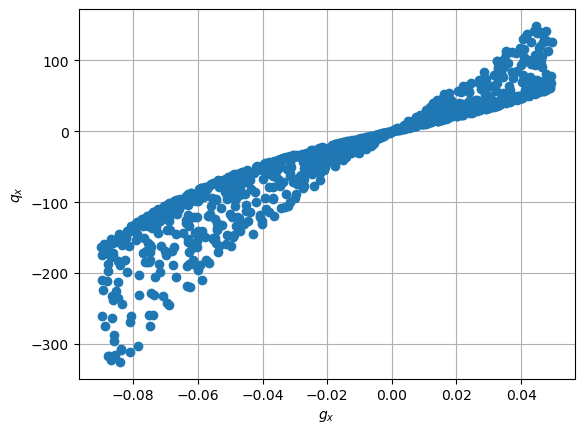

In [12]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
from ddfenics.dd.ddmaterial import DDMaterial 

database_file = 'database_generated.txt'

Nd = 1000 # number of points
noise = 0.01
g_range = np.array([[-0.09, -0.05], [0.05,0.15]])

qL = 100.0
qT = 10.0
c1 = 6.0
c2 = 3.0
c3 = 500.0

alpha_0 = 1000.0
beta = 1e2

# alpha : Equivalent to sig = lamb*df.div(u)*df.Identity(2) + mu*(df.grad(u) + df.grad(u).T)
def flux(g):
    g2 = np.dot(g,g)
    alpha = alpha_0*(1+beta*g2)
    return alpha*g

np.random.seed(1)
DD = np.zeros((Nd,2,2))

for i in range(Nd):
    DD[i,0,:] = g_range[0,:] + np.random.rand(2)*(g_range[1,:] - g_range[0,:])
    DD[i,1,:] = flux(DD[i,0,:]) + noise*np.random.randn(2)
    
np.savetxt(database_file, DD.reshape((-1,4)), header = '1.0 \n%d 2 2 2'%Nd, comments = '', fmt='%.8e', )

ddmat = DDMaterial(database_file)  # replaces sigma_law = lambda u : ...

plt.plot(DD[:,0,0], DD[:,1,0], 'o')
plt.xlabel('$g_x$')
plt.ylabel('$q_x$')
plt.grid()

2) **Mesh** (Unchanged) 

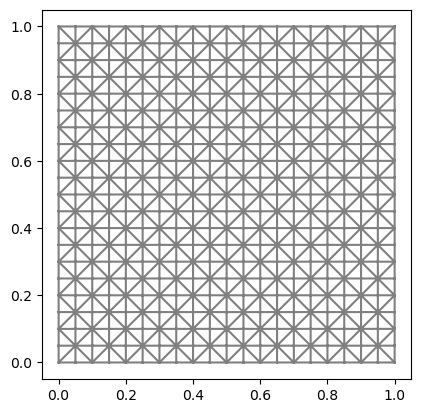

In [13]:
Nx =  20 
Ny =  20 
Lx = 1.0
Ly = 1.0
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** (Unchanged)

In [14]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

bottomBnd = df.CompiledSubDomain('near(x[1], 0.0) && on_boundary')
topBnd = df.CompiledSubDomain('near(x[1], Ly) && on_boundary', Ly=Ly)

leftFlag = 4
rightFlag = 2
bottomFlag = 1
topFlag = 3

boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, leftFlag)
rightBnd.mark(boundary_markers, rightFlag)
bottomBnd.mark(boundary_markers, bottomFlag)
topBnd.mark(boundary_markers, topFlag)


dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces** (Unchanged)

In [15]:
from ddfenics.dd.ddspace import DDSpace

Uh = df.FunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcBottom = df.DirichletBC(Uh, df.Constant(0.0), boundary_markers, bottomFlag)
bcRight = df.DirichletBC(Uh, df.Constant(0.0), boundary_markers, rightFlag)
bcs = [bcBottom, bcRight]

# Space for stresses and strains
Sh0 = DDSpace(Uh, 2, 'DG') 

spaces = [Uh, Sh0]

5) **Variational Formulation**: <br>

- Strong format: 
$$
\begin{cases}
- div \mathbf{q} = f  \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \cup \Gamma_3 \\
\mathbf{g} = \nabla u \quad \text{in} \, \Omega \\
\mathbf{q} \cdot n  = \bar{q}_{2,4} \quad \text{on} \, \Gamma_2 \cup \Gamma_4 \\
\end{cases}
$$ 
- DD equilibrium subproblem: Given $(\varepsilon^*, \sigma^*) \in Z_h$, solve for $(u,\eta) \in U_h$  
$$
\begin{cases}
(\mathbb{C} \nabla^s u , \nabla^s v ) = (\mathbb{C} \mathbf{g}^* , \nabla v ) \quad \forall v \in U_h, \\
(\mathbb{C} \nabla^s \eta , \nabla^s \xi ) = \Pi_{ext}(\xi) - (\mathbf{q}^* , \nabla \xi ) \quad \forall \xi \in U_h \\
\end{cases}
$$
- Updates:
$$
\begin{cases}
\mathbf{g} = \nabla u \\
\mathbf{q} = \mathbf{q}^* + \mathbb{C} \nabla \eta
\end{cases}
$$
- DD ''bilinear'' form : $(\bullet , \nabla v)$ or sometimes  $(\mathbb{C} \nabla \bullet, \nabla v)$ 

In [16]:
# Changed
from ddfenics.dd.ddmetric import DDMetric

# Unchanged
x = df.SpatialCoordinate(mesh)

flux_left = df.Constant(qL)
flux_top = df.Constant(qT)
source = c3*df.sin(c1*x[0])*df.cos(c2*x[1])

# changed 
P_ext = lambda w : source*w*dx + flux_left*w*ds(leftFlag) + flux_top*w*ds(topFlag)

dddist = DDMetric(ddmat = ddmat, V = Sh0, dx = dx)

print(dddist.CC)

[[ 2.17430849e+03 -1.56998139e+02  0.00000000e+00  0.00000000e+00]
 [-1.56998139e+02  2.62156753e+03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.61913751e-04  2.76626861e-05]
 [ 0.00000000e+00  0.00000000e+00  2.76626861e-05  3.83107809e-04]]


6) **Statement and Solving the problem** <br> 
- DDProblem : States DD equilibrium subproblem and updates.
- DDSolver : Implements the alternate minimization using SKlearn NearestNeighbors('ball_tree', ...) searchs for the projection onto data.
- Stopping criteria: $\|d_k - d_{k-1}\|/energy$

In [17]:
from ddfenics.dd.ddfunction import DDFunction
from ddfenics.dd.ddproblem_poisson import DDProblemPoisson as DDProblem # Generic implementation
from ddfenics.dd.ddsolver import DDSolver
from ddfenics.dd.ddproblem_generic import DDProblemGeneric # Generic implementation
from ddfenics.dd.ddbilinear import DDBilinear

uh = df.TrialFunction(Uh)
vh = df.TestFunction(Uh)
a = DDBilinear(dddist, df.grad, uh, vh, dx = Sh0.dxm)


# replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
problem = DDProblem(spaces, df.grad, L = P_ext, bcs = bcs, metric = dddist) 
# problem = DDProblemGeneric(spaces, a, L = P_ext(vh), bcs = bcs, metric = dddist) 
sol = problem.get_sol()

start = timer()

#replaces df.LinearVariationalSolver(problem)
solver = DDSolver(problem, ddmat, opInit = 'zero', seed = 2)
tol_ddcm = 1e-8
solver.solve(tol = tol_ddcm, maxit = 100);

end = timer()

uh = sol["u"]
normL2 = df.assemble(df.inner(uh,uh)*dx)
norm_energy = df.assemble(df.inner(sol['state_mech'][0],sol['state_mech'][1])*dx)

print("Time spent: ", end - start)
print("Norm L2: ", normL2)
print("Norm energy: ", norm_energy)

number of gauss points =  1
number of gauss points =  1
number of gauss points =  1
number of gauss points =  1
	Inner Iteration #  1 ,- Relative Error =  6.206259e-01
	Inner Iteration #  2 ,- Relative Error =  5.294930e-01
	Inner Iteration #  3 ,- Relative Error =  2.000895e-01
	Inner Iteration #  4 ,- Relative Error =  1.728109e-01
	Inner Iteration #  5 ,- Relative Error =  6.634426e-02
	Inner Iteration #  6 ,- Relative Error =  2.363457e-01
	Inner Iteration #  7 ,- Relative Error =  2.007305e-01
	Inner Iteration #  8 ,- Relative Error =  3.371884e-01
	Inner Iteration #  9 ,- Relative Error =  3.194534e-01
	Inner Iteration # 10 ,- Relative Error =  3.662533e-01
	Inner Iteration # 11 ,- Relative Error =  3.375186e-01
	Inner Iteration # 12 ,- Relative Error =  3.336798e-01
	Inner Iteration # 13 ,- Relative Error =  2.972617e-01
	Inner Iteration # 14 ,- Relative Error =  2.905409e-01
	Inner Iteration # 15 ,- Relative Error =  2.654421e-01
	Inner Iteration # 16 ,- Relative Error =  2.604

7) **Plotting**

a) *Minimisation*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


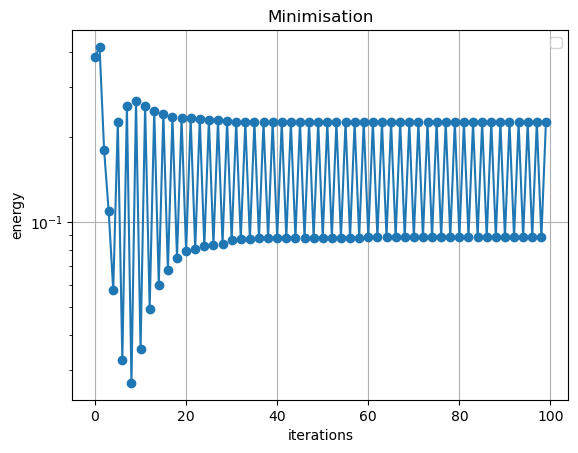

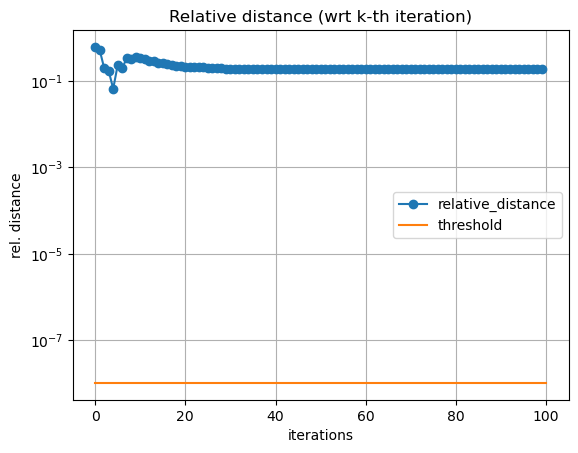

In [18]:
hist = solver.hist

fig = plt.figure(2)
plt.title('Minimisation')
plt.plot(hist['relative_energy'], 'o-')
plt.xlabel('iterations')
plt.ylabel('energy')
plt.legend(loc = 'best')
plt.yscale('log')
plt.grid()

fig = plt.figure(3)
plt.title('Relative distance (wrt k-th iteration)')
plt.plot(hist['relative_distance'], 'o-', label = "relative_distance")
plt.plot([0,len(hist['relative_energy'])],[tol_ddcm,tol_ddcm], label = "threshold")
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('rel. distance')
plt.legend(loc = 'best')
plt.grid()

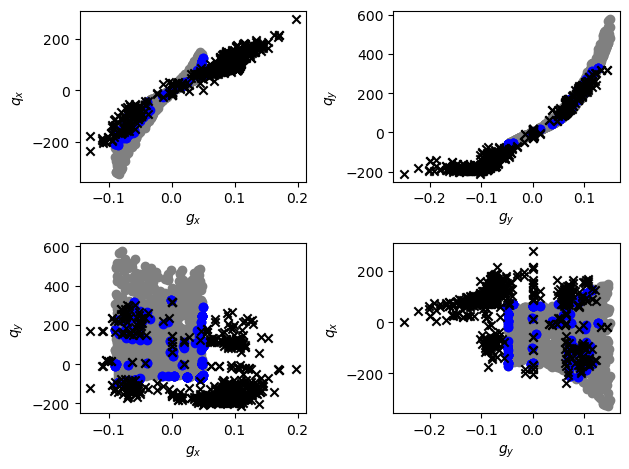

In [19]:
state_mech = sol["state_mech"]
state_db = sol["state_db"]

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

ax1.set_xlabel(r'$g_{x}$')
ax1.set_ylabel(r'$q_{x}$')
ax1.scatter(ddmat.DB[:, 0, 0], ddmat.DB[:, 1, 0], c='gray')
ax1.scatter(state_db[0].data()[:,0], state_db[1].data()[:,0], c='blue')
ax1.scatter(state_mech[0].data()[:,0], state_mech[1].data()[:,0], marker = 'x', c='black')

ax2.set_xlabel(r'$g_{y}$')
ax2.set_ylabel(r'$q_{y}$')
ax2.scatter(ddmat.DB[:, 0, 1], ddmat.DB[:, 1, 1], c='gray')
ax2.scatter(state_db[0].data()[:,1], state_db[1].data()[:,1], c='blue')
ax2.scatter(state_mech[0].data()[:,1], state_mech[1].data()[:,1], marker = 'x', c='black')


ax3.set_xlabel(r'$g_{x}$')
ax3.set_ylabel(r'$q_{y}$')
ax3.scatter(ddmat.DB[:, 0, 0], ddmat.DB[:, 1, 1], c='gray')
ax3.scatter(state_db[0].data()[:,0], state_db[1].data()[:,1], c='blue')
ax3.scatter(state_mech[0].data()[:,0], state_mech[1].data()[:,1], marker = 'x', c='black')

ax4.set_xlabel(r'$g_{y}$')
ax4.set_ylabel(r'$q_{x}$')
ax4.scatter(ddmat.DB[:, 0, 1], ddmat.DB[:, 1, 0], c='gray')
ax4.scatter(state_db[0].data()[:,1], state_db[1].data()[:,0], c='blue')
ax4.scatter(state_mech[0].data()[:,1], state_mech[1].data()[:,0], marker = 'x', c='black')

plt.tight_layout()

In [20]:
from ddfenics.utils.postprocessing import *
output_sol_ref = "square_fe_sol.xdmf"
errors = comparison_with_reference_sol(sol, output_sol_ref, labels = ['u','g','q'])

output_vtk = "square_dd_vtk.xdmf"
generate_vtk_db_mech(sol, output_vtk, labels = ["u", "g", "q"])

number of gauss points =  1
number of gauss points =  1
Norm u : 8.756024e-01
Norm sig_db : 2.441105e+00
Norm eps_db : 1.184410e+00
Norm sig_mech : 3.350642e+00
Norm eps_mech : 1.868436e+00
8.756024e-01, 2.441105e+00, 1.184410e+00, 3.350642e+00, 1.868436e+00
